## Control work

**Variant:** SIR model <br>
**Author:** Danis Alukaev <br>
**Group:** B19-DS-01 <br>
**Email:** d.alukaev@innopolis.university

In [66]:
%matplotlib inline
import pysd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm

## 0. Problem Statement

### 0.1. Loading the original model

In [2]:
model = pysd.load('sir.py')

In [3]:
output = model.run(return_columns=['Infected', 'Recovered'])

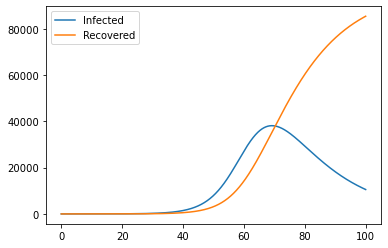

In [4]:
output.plot()
plt.show()

Population is divided into three categories according to their condition: $Susceptible$, $Infected$ and $Recovered$. As people become infected, they move from the $Suspicious$ category to the $Infected$ category, and then, as they recover, to the $Recovered$ category. The disease spreads as infected people contact with the susceptible person. Recovery occurs after some time.

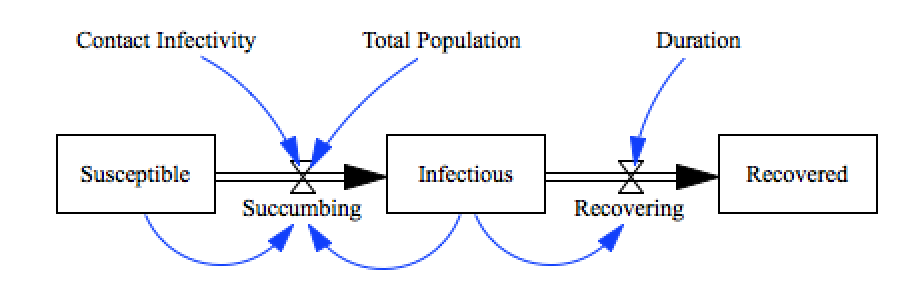

### 0.2. Task (perform in a separate .py and .ipynb files)
Implement additionally the following logic:
1. Make the initial number of infected persons not a constant, but a parameter of the model. Make the $infectivity$ parameter a function of the number of infected (may be not only, up to you), according to the realities of life (set the function yourself).
2. Add the possibility of death from the disease with some "probability" $p$ ($p$ is a parameter).
3. Implement the possibility of re-infection after a certain period of decline in immunity $L$ ($L$ is a parameter).

Output a graph of infected people by time, as well as calculate the mean and variance of the number of recovered at the 50th step of the simulation when the parameters $L$ vary from $5$ to $10$ (step is $1$), $p$ from $0.01$ to $0.1$ (step is $0.01$) and $ContactRate$ from $3$ to $10$ (step is $1$).

## 1. Parametrizing Infectious

In `sir-1.py` in funciton `_integ_infected` there was changed default value to `initial_infected`.

In [54]:
model = pysd.load('sir-1.py')

Let's start with making an initial number of infected people parameter of the model. I have created auxiliary method `run_model` that accepts the model itself and optional dictionary with parameters that will be used for simulation. For a further convinience there is also defined method that makes plot of simulation.

In [55]:
def run_model(model, params=None, return_columns=None):
    """Simulate system dynamics using SIR model.
    
    Parameters
    ----------
    model : pysd.py_backend.statefuls.Model
        loaded SIR model
    
    params : dict or None
        dictionary with default parameters
    
    return_columns : list or None
        list of column names to return
    
    Returns
    -------
    values : pandas.DataFrame
        dataframe with interested columns 
    """
    model.reload()
    kwargs = {}
    if params is not None:
        kwargs['params'] = params
    if return_columns is not None:
        kwargs['return_columns'] = return_columns
    values = model.run(**kwargs)
    return values

In [56]:
def plot_chart(df):
    """Visualize simulation.
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe with values to visualize
        max supported ammount of columns = 4
        
    Returns
    -------
    None
    """
    labels = df.columns
    assert len(labels) < 5, "Maximal number of columns is 4"
    colors = ['g', 'b', 'r', 'k'][:len(labels)]
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 12)
    ax1.set_title(f"System Dynamics")
    ax1.grid(linestyle="--")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Data")
    x = df.index.values
    for label, color in zip(labels, colors):
        ax1.plot(x, df[label], '-', label=label, c=color)
    ax1.legend()
    ax1.set_xlim([min(x), max(x)])
    plt.show() 

Here I defined config dictionary with parameter `initial_infected` that can be changed on demand.

In [138]:
config = {
    "total_population": 1e5,
    "initial_infected": 20,
    "final_time": 100
}
assert config["total_population"] > config["initial_infected"]

In [139]:
df = run_model(model, params=config, return_columns=['Susceptible', 'Infected', 'Recovered'])

In [140]:
df

,Susceptible,Infected,Recovered
0.00000,99980.000000,20.000000,0.000000
0.03125,99979.687562,20.270771,0.039583
0.06250,99979.371691,20.544589,0.079526
0.09375,99979.052342,20.821491,0.119832
0.12500,99978.729476,21.101514,0.160506
...,...,...,...
99.87500,20201.032268,45591.062853,20542.705158
99.90625,20201.037214,45587.785031,20541.228965
99.93750,20201.042142,45584.507466,20539.752874
99.96875,20201.047052,45581.230157,20538.276887


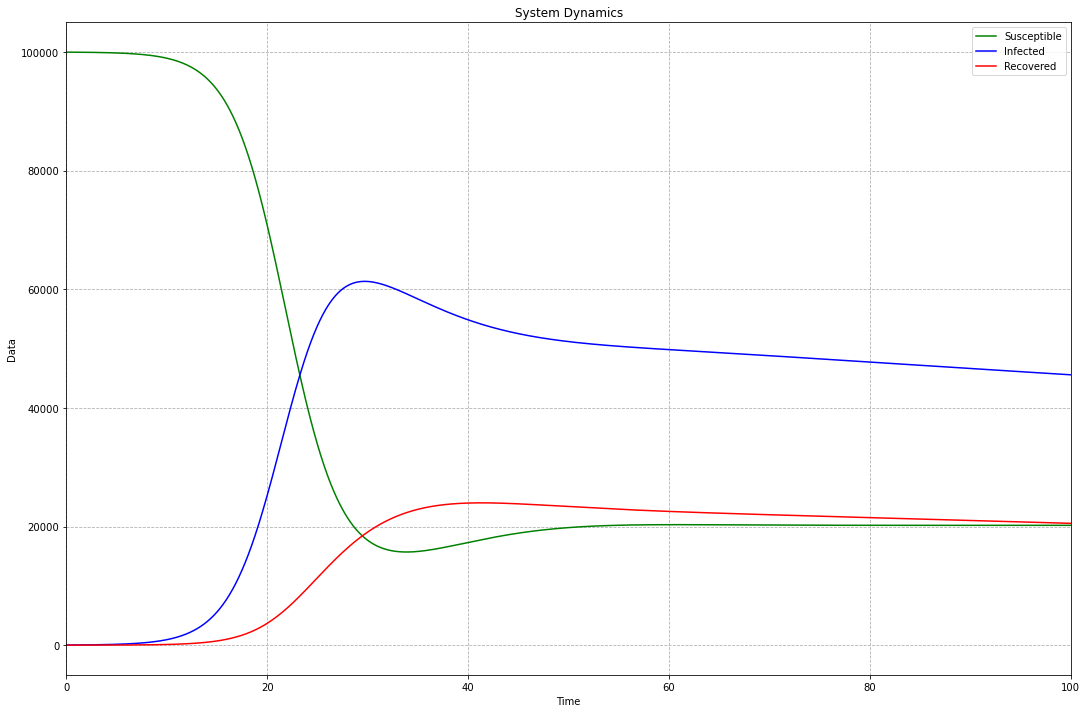

In [141]:
plot_chart(df)

Note that the first value in "Infected" column is equal to which we set in config dict.

There were also introduced new function of infectivity equalling to `0.1 * math.exp(-recovered() / (infected() + 1e-7))` that seems to be a good approximation of real-world scenarios.

## 2. Container Death 

Created new python file `sir-2.py` all changes marked with keywords `2. CHANGES` and `2. END OF CHANGES`. There were introduced new constant `death_rate` that is $p$ and auxiliary functions `_integ_dead`, `dead`, and `death`. To preserve the consistency of all flows, in `recovery` function there was added multiplier $(1-p)$ and to `death` - $p$.

In [142]:
model = pysd.load('sir-2.py')

In [143]:
df = run_model(model, params=config, return_columns=['Susceptible', 'Infected', 'Recovered', 'Dead'])

In [144]:
df

,Susceptible,Infected,Recovered,Dead
0.00000,99980.000000,20.000000,0.000000,0.000000
0.03125,99979.687562,20.270771,0.039583,0.002083
0.06250,99979.371514,20.544589,0.079703,0.004195
0.09375,99979.051814,20.821488,0.120364,0.006335
0.12500,99978.728421,21.101502,0.161573,0.008504
...,...,...,...,...
99.87500,7918.215054,612.501822,86895.818968,4573.464156
99.90625,7918.215054,611.225776,86897.031212,4573.527959
99.93750,7918.215054,609.952389,86898.240929,4573.591628
99.96875,7918.215054,608.681655,86899.448127,4573.655165


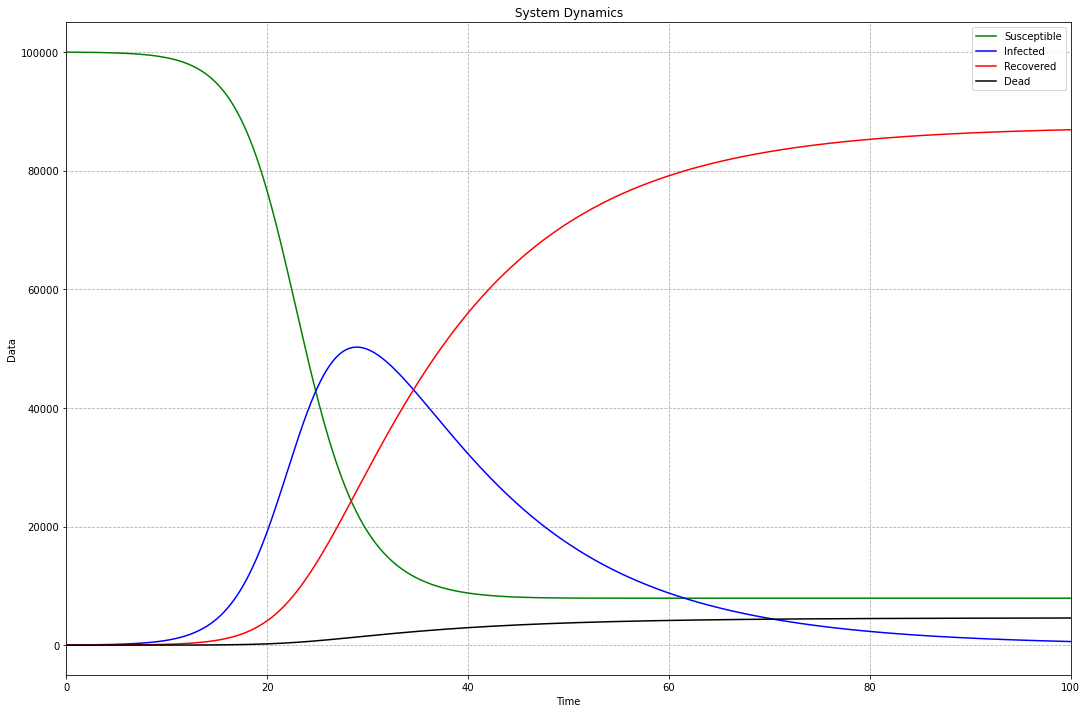

In [145]:
plot_chart(df)

## 3. Re-infection

Created new python file `sir-3.py` all changes marked with keywords `3. CHANGES` and `3. END OF CHANGES`. There were introduced new constant `period_loss_immunity` that is $L$ and auxiliary function `immune_loss` that equals to number of recovered divided by `period_loss_immunity`. This function is subtracted from container recovered and added to container susceptible.

In [17]:
model = pysd.load('sir-3.py')

In [18]:
df = run_model(model, params=config, return_columns=['Susceptible', 'Infected', 'Recovered', 'Dead'])

In [19]:
df

,Susceptible,Infected,Recovered,Dead
0.00000,99980.000000,20.000000,0.000000,0.000000
0.03125,99979.687562,20.270771,0.039583,0.002083
0.06250,99979.371691,20.544589,0.079526,0.004195
0.09375,99979.052342,20.821491,0.119832,0.006335
0.12500,99978.729476,21.101514,0.160506,0.008504
...,...,...,...,...
99.87500,20201.032268,45591.062853,20542.705158,13665.199722
99.90625,20201.037214,45587.785031,20541.228965,13669.948791
99.93750,20201.042142,45584.507466,20539.752874,13674.697518
99.96875,20201.047052,45581.230157,20538.276887,13679.445904


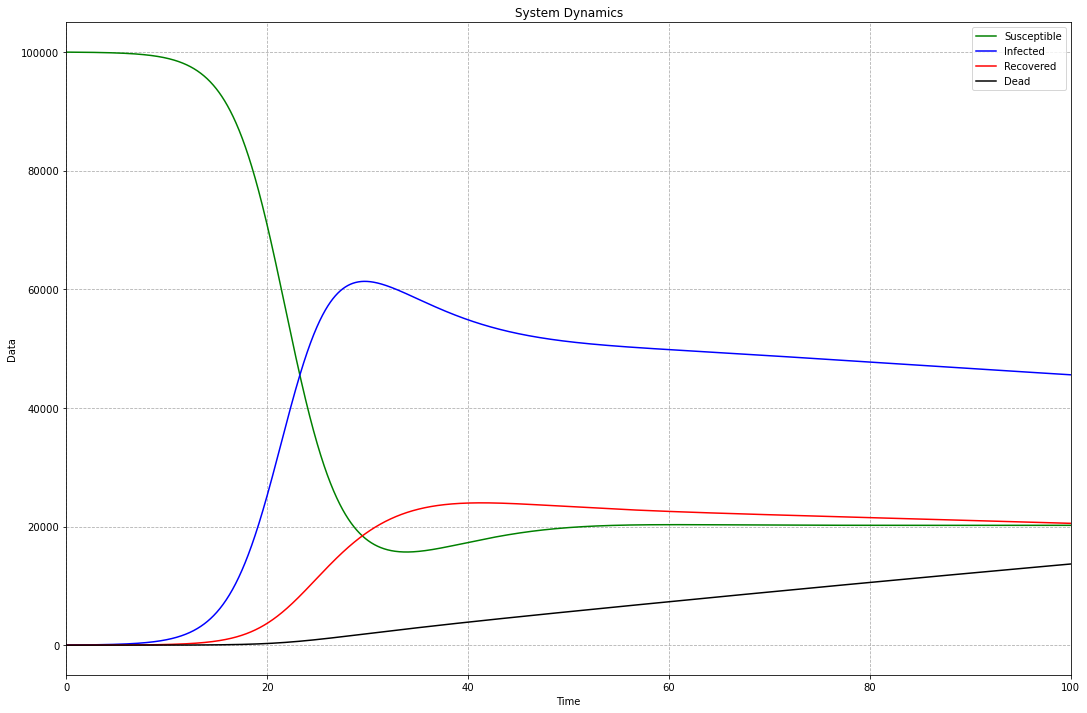

In [21]:
plot_chart(df)

## 4. Analysis

The following cells dedicated to collection of final state of systems at time moment $T=50$. And computing mean and variance of recovered people in all simulations. There is used `sir-3.py` model with alternating set of parameters $L$, $p$, and $contact_rate$.

In [148]:
model = pysd.load('sir-3.py')

In [73]:
parameter_space = {
    "period_loss_immunity": np.arange(5, 11, 1),
    "death_rate": np.arange(0.01, 0.11, 0.01),
    "contact_rate": np.arange(3, 11, 1)
}

In [74]:
def create_grid(params):
    """Create parameter space.
    
    Parameters
    ----------
    params : dict
        dictionary keys period_loss_immunity, death_rate, contact_rate 
        and values numpy arrays
    
    Returns
    -------
    combinations : list
        list of tuples with values of period_loss_immunity,
        death_rate and contact_rate
    """
    combinations = list(itertools.product(params['period_loss_immunity'], params['death_rate'], params['contact_rate']))
    return combinations

In [118]:
def run_simulations(model, grid):
    """Run simulations of SIR model by parameter space.
    
    Parameters
    ----------
    model : pysd.py_backend.statefuls.Model
        loaded SIR model (v.3)
    
    grid : list
        list of tuples with values of period_loss_immunity,
        death_rate and contact_rate
    
    Returns
    -------
    df : pandas.DataFrame
        50-th step (time) of each simulation
    """
    columns = ['Susceptible', 'Infected', 'Recovered', 'Dead']
    df = pd.DataFrame(columns=columns)
    for idx, params in enumerate(tqdm(grid)):
        config = {
            "total_population": 1e5,
            "final_time": 50,
            "period_loss_immunity": params[0],
            "death_rate": params[1],
            "contact_rate": params[2]
        }
        df_ = run_model(model, params=config, return_columns=columns)
        roi = df_.iloc[-1]
        df.loc[idx] = roi
    return df 

In [119]:
grid = create_grid(parameter_space)

In [120]:
experiments = run_simulations(model, grid)

100%|█████████████████████████████████████████| 480/480 [01:36<00:00,  4.95it/s]


In [121]:
experiments.to_csv("experiments.csv")

In [122]:
experiments = pd.read_csv("experiments.csv")

In [123]:
experiments

,Unnamed: 0,Susceptible,Infected,Recovered,Dead
0,0,88064.506167,10068.471701,1827.425907,39.596225
1,1,23534.589944,59315.751295,16673.588605,476.070157
2,2,17705.484530,61161.346533,20222.081109,911.087828
3,3,15325.165907,62687.151915,20797.828455,1189.853723
4,4,13172.038397,64190.834976,21250.857415,1386.269212
...,...,...,...,...,...
475,475,17829.383096,43903.677943,28160.090110,10106.848851
476,476,16483.155005,43889.497121,28103.615014,11523.732859
477,477,14706.573809,44499.486973,28224.759098,12569.180121
478,478,13096.077437,45098.887066,28423.953952,13381.081545


In [135]:
mean_recovered = experiments.Recovered.mean()
var_recovered = experiments.Recovered.var()

In [137]:
print(f"Recovered mean={mean_recovered:.3f}, variance={var_recovered:.3f}")

Recovered mean=21569.370, variance=74228679.615


In [146]:
def generate_simulations(model, grid):
    """Run simulations of SIR model by parameter space.
    
    Parameters
    ----------
    model : pysd.py_backend.statefuls.Model
        loaded SIR model (v.3)
    
    grid : list
        list of tuples with values of period_loss_immunity,
        death_rate and contact_rate
    
    Returns
    -------
    df : pandas.DataFrame
        50-th step (time) of each simulation
    """
    columns = ['Susceptible', 'Infected', 'Recovered', 'Dead']
    simulations = []
    for idx, params in enumerate(tqdm(grid)):
        config = {
            "total_population": 1e5,
            "final_time": 50,
            "period_loss_immunity": params[0],
            "death_rate": params[1],
            "contact_rate": params[2]
        }
        df_ = run_model(model, params=config, return_columns=columns)
        simulations.append(df_)
    return simulations

In [149]:
simulations = generate_simulations(model, grid)

100%|█████████████████████████████████████████| 480/480 [01:37<00:00,  4.95it/s]


In [150]:
simulations_dict = dict(zip(grid, simulations))

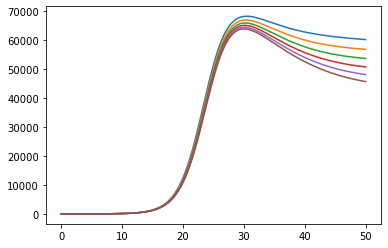

In [179]:
period_loss_immunity_exploration = []
death_rate = 0.05
contact_rate = 6
for key, value in simulations_dict.items():
    if key[1] == death_rate and key[2] == contact_rate:
        period_loss_immunity_exploration.append(value)
        
period_loss_immunity_exploration = [x.Infected for x in period_loss_immunity_exploration]
for value in period_loss_immunity_exploration:
    plt.plot(value)
plt.show()

Loss immunity parameter $L$ increases the number of infected over time.

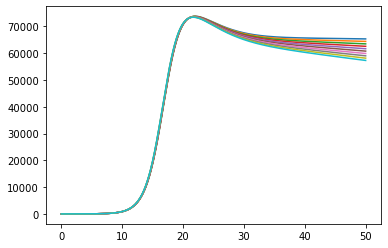

In [182]:
death_rate_exploration = []
loss_immunity = 5
contact_rate = 8
for key, value in simulations_dict.items():
    if key[0] == loss_immunity and key[2] == contact_rate:
        death_rate_exploration.append(value)
        
death_rate_exploration = [x.Infected for x in death_rate_exploration]
for value in death_rate_exploration:
    plt.plot(value)
plt.show()

Death rate parameter $p$ mostly affects final number of infected, because overall number of alive people decreasing.

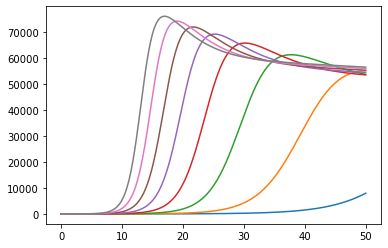

In [181]:
contact_rate_exploration = []
loss_immunity = 7
death_rate = 0.05
for key, value in simulations_dict.items():
    if key[0] == loss_immunity and key[1] == death_rate:
        contact_rate_exploration.append(value)
        
contact_rate_exploration = [x.Infected for x in contact_rate_exploration]
for value in contact_rate_exploration:
    plt.plot(value)
plt.show()

Contact rate parameter speeds up the process of infecting.